In [1]:
import pandas as pd
import numpy as np
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
classification_report, roc_auc_score, roc_curve, auc

from sklearn.preprocessing import label_binarize

from itertools import cycle

import matplotlib.pyplot as plt

from scipy.special import softmax

import pickle

In [2]:
# 0 - negative
# 1 - somewhat negative
# 2 - neutral
# 3 - somewhat positive
# 4 - positive

In [3]:
train = pd.read_csv('data/train.tsv', sep="\t")
test = pd.read_csv('data/test.tsv', sep="\t")

In [4]:
train_len = int(len(train)*0.7)

train_df = train.iloc[0: train_len][['Phrase','Sentiment']].rename(columns={'Phrase':'text','Sentiment':'labels'})
eval_df = train.iloc[train_len: ][['Phrase','Sentiment']].rename(columns={'Phrase':'text','Sentiment':'labels'})

test_df = test[['Phrase']].rename(columns={'Phrase':'text'})

In [5]:
train.shape, train_df.shape, eval_df.shape

((156060, 4), (109242, 2), (46818, 2))

In [6]:
from simpletransformers.classification import ClassificationModel

In [7]:
model = ClassificationModel('roberta', 'roberta-base', 
                            num_labels=5,
                           args = {
                               'overwrite_output_dir': True,
                               'reprocess_input_data': True,
                               'output_dir': 'outputs/',
                               'cache_dir': 'cache_dir/',
                               'max_seq_length': 128,
                               'num_train_epochs': 1,
                                  }
                           )
model.train_model(train_df)


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


Running loss: 1.674168

C:\Users\Chern\miniconda3\envs\py37\lib\site-packages\torch\optim\lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Running loss: 1.529697

C:\Users\Chern\miniconda3\envs\py37\lib\site-packages\torch\optim\lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 1.677881Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 1.356343Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Running loss: 0.976512Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Running loss: 1.031844Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.952977Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 0.829911

C:\Users\Chern\miniconda3\envs\py37\lib\site-packages\torch\optim\lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running loss: 1.394921Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 0.969186Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Running loss: 1.067585Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Running loss: 1.124643



In [8]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df,  acc=accuracy_score)
y_pred = model_outputs.argmax(axis=1)
y_pred_proba = softmax(model_outputs, axis=1)

In [9]:
y_test = eval_df['labels']
y_test_binary = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

In [10]:
print('Trained')
print(classification_report( y_test, y_pred ))
print(precision_score( y_test, y_pred, average='weighted'))
print(roc_auc_score( y_test.values, y_pred_proba, multi_class='ovo'))

Trained
              precision    recall  f1-score   support

           0       0.50      0.39      0.44      2186
           1       0.57      0.56      0.57      8777
           2       0.76      0.79      0.77     23110
           3       0.60      0.58      0.59      9853
           4       0.56      0.55      0.55      2892

    accuracy                           0.67     46818
   macro avg       0.60      0.58      0.58     46818
weighted avg       0.67      0.67      0.67     46818

0.6656159524890425
0.8886620093525914


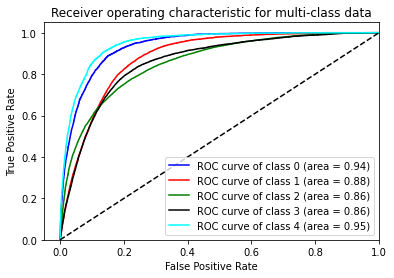

In [11]:
n_classes = 5
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'black', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [12]:
submission_pred, submission_pred_proba = model.predict(test_df.text.values.tolist())
submission_df = pd.concat( [test_df , pd.Series(submission_pred)], axis=1)
submission_df = pd.concat([test['PhraseId'], submission_df.drop('text',axis=1)], axis=1)
submission_df.columns = ['PhraseId','Sentiment']
submission_df.to_csv('test_submission.csv', index=False)